<a href="https://colab.research.google.com/github/vin136/sample-test/blob/master/mine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!git clone https://github.com/vin136/sample-test.git

fatal: destination path 'sample-test' already exists and is not an empty directory.


In [10]:
import sys
!{sys.executable} -m pip install folium scikit-plot plotly xgboost graphviz

In [11]:
#Libraries
import pandas as pd
pd.set_option("display.max_columns", 101)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.gridspec as grid_spec
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import scikitplot as skplt
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score, f1_score

In [72]:
loc = '/content/sample-test/train.csv'
data =pd.read_csv(loc)

In [73]:
def initial_eda(df):
    total_na = df.isna().sum().sum()
    print("Dimensions : %d rows, %d columns" % (df.shape[0], df.shape[1]))
    print("Total NA Values : %d " % (total_na))
    print("%38s %10s     %10s %10s" % ("Column Name", "Data Type", "#Distinct", "NA Values"))
    col_name = df.columns
    dtyp = df.dtypes
    uniq = df.nunique()
    na_val = df.isna().sum()
    for i in range(len(df.columns)):
        print("%38s %10s   %10s %10s" % (col_name[i], dtyp[i], uniq[i], na_val[i]))

In [74]:
initial_eda(data)

Dimensions : 2870 rows, 12 columns
Total NA Values : 676 
                           Column Name  Data Type      #Distinct  NA Values
                                    id      int64         2870          0
                                region     object            5          0
                              latitude    float64         2647          0
                             longitude    float64         2550          0
                    accommodation_type     object            3          0
                                  cost      int64          330          0
                        minimum_nights      int64           53          0
                     number_of_reviews      int64          160          0
                     reviews_per_month    float64          419        676
                              owner_id      int64         2371          0
                          owned_hotels      int64           40          0
                   yearly_availability      int64   

Index(['id', 'region', 'latitude', 'longitude', 'accommodation_type', 'cost',
       'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'owner_id',
       'owned_hotels', 'yearly_availability'],
      dtype='object')

## Exploring distributions of input

Note: The objective of eda here is to give insights about modeling,not just to show nice visualizations.

In [176]:
%matplotlib inline
import scipy.stats as stats


#objective: identify the distribution of the variable and detect outliers
def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

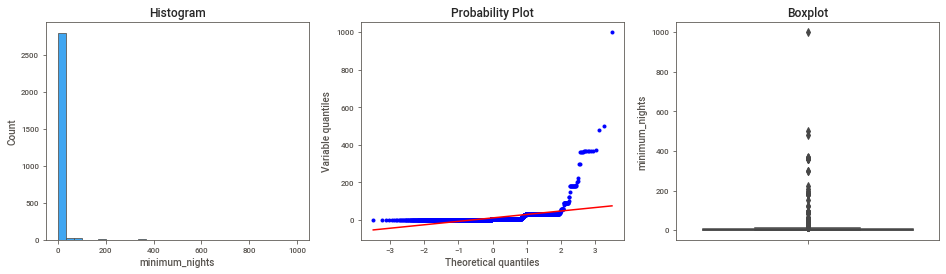

In [177]:
# colums of interest = cost ,minimum_nights ,number_of_reviews ,reviews_per_month   
diagnostic_plots(data,'minimum_nights')                            

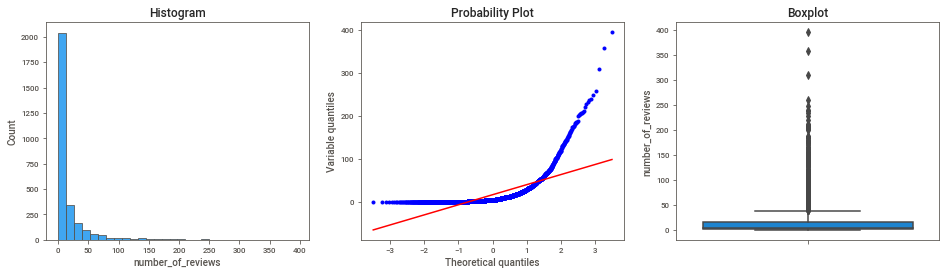

In [178]:
diagnostic_plots(data,'number_of_reviews')                            

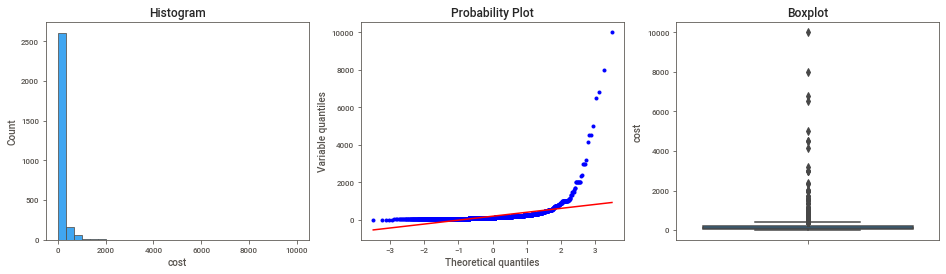

In [179]:
diagnostic_plots(data,'cost')                            

`obs`: extreme outliers or heavy tailed distribution(not necessarily a bad thing). From modeling standpoint, any standardisation (min-max,mean etc) will squeeze the range unnecessarily if done without capping/other outlier handling methods.

# Variable charecterization

## missing variable

Ideally missingness should be further investigated. (MCAR,MAR,MNAR)

In [93]:
#smell testing if missingness is at random or does missingness have any strong predictive power 
is_missing = data[['reviews_per_month']].isna()['reviews_per_month']
avg_missing = data[is_missing]['yearly_availability'].mean()
avg_notmissing = data[~is_missing]['yearly_availability'].mean()
print(f'avg availability for missing reviews:{avg_missing},non-missing:{avg_notmissing}')


avg availability for missing reviews:0.7633136094674556,non-missing:0.4170464904284412


Since the data-set size is low and also initial smell test suggests possible predictive power, I choose to encode the missingness in the training pipeline. I would find the best imputation technique.



In [106]:
percent_missing = is_missing.sum()*100/len(is_missing)
percent_missing # this is a big number,thus it matters how we choose to impute as any method(mean,median etc)
#will drastically alter the distribution

23.554006968641115

In [138]:
# import classes for imputation
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# import extra classes for modelling
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, GridSearchCV

np.random.seed(0)

In [141]:
#owner_id is removed,so is owned_hotels.

X = data[['region', 'latitude', 'longitude', 'accommodation_type', 'cost',
       'minimum_nights', 'number_of_reviews', 'reviews_per_month']]
Y = data['yearly_availability']


# find categorical variables
# those of type 'Object' in the dataset
features_categorical = [c for c in X.columns if X[c].dtypes=='O']

# find numerical variables
# those different from object and also excluding the target SalePrice
features_numerical = [c for c in X.columns if X[c].dtypes!='O' and c !='yearly_availability']




#scaling never hurts
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

#just to safegaurd, imputation is added here too
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numeric_transformer, features_numerical),
        ('categorical', categorical_transformer, features_categorical)])

#here constant = 0,find best imputation strategy
param_grid = {
    'preprocessor__numerical__imputer__strategy': ['mean', 'median','constant']
}





In [142]:
X.shape,Y.shape

((2870, 8), (2870,))

In [143]:
from sklearn.ensemble import RandomForestClassifier
# instantiate the classifier 
rfc = RandomForestClassifier(random_state=0, n_estimators = 10)
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', rfc)])

grid_search = GridSearchCV(clf, param_grid, cv=5,n_jobs=-1, scoring='accuracy')



In [144]:
grid_search.fit(X,Y.values)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['latitude',
                                                                          'longitude',
                                                                          'cost',
                                                                          'minimum_nights',
                                                       

In [145]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['latitude', 'longitude',
                                                   'cost', 'minimum_nights',
                                                   'number_of_reviews',
                                                   'reviews_per_month']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
            

In [146]:
print(("best random forest fit from grid search: %.3f"
       % grid_search.score(X, Y)))

# Note that this is cross-val score,this gives a reasonable estimate for generalization performance

best random forest fit from grid search: 0.995


Here we see that simple imputation with `constant` gives best score. 

In [147]:
# for completeness I'll also do the same with logistic regression

from sklearn.linear_model import LogisticRegression
# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression()

clf_lr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', logisticRegr)])

grid_search_lr = GridSearchCV(clf_lr, param_grid, cv=5,n_jobs=-1, scoring='accuracy')
grid_search_lr.fit(X,Y.values)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['latitude',
                                                                          'longitude',
                                                                          'cost',
                                                                          'minimum_nights',
                                                       

In [148]:
grid_search_lr.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['latitude', 'longitude',
                                                   'cost', 'minimum_nights',
                                                   'number_of_reviews',
                                                   'reviews_per_month']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                               

In [149]:
print(("best random forest fit from grid search: %.3f"
       % grid_search_lr.score(X, Y)))


best random forest fit from grid search: 0.875


Here median comes out to be the best imputer.(this also matches my intuition). Thus When comparing models,I'll search over imputation techniques too.

In [156]:
#encoder = OneHotEncoder(categories='auto',
                      # drop='first', # to return k-1, use drop=false to return k dummies
                      # sparse=False,
                      # handle_unknown='error') # helps deal with rare labels



## Categorical variables and cardinality

Is there high cardinality?

High cardinality poses the following challenges: 

- Variables with too many labels tend to dominate those with only a few labels, particularly in **decision tree-based** algorithms.

- High cardinality may introduce noise.

**Algorithms based on decision trees can be biased towards variables with high cardinality**.

Thus I choose to drop `id`,`owner_id`.


Categories to study: `accommodation_type`,`region `

In [96]:
#Let's find the categorical variables
categorical = [var for var in data.columns if data[var].dtype=='O']

print('There are {} categorical variables\n'.format(len(categorical)))

print('The categorical variables are :\n\n', categorical)

There are 2 categorical variables

The categorical variables are :

 ['region', 'accommodation_type']


Varia

In [97]:
data[['region','yearly_availability']].groupby('region').describe()

yearly_availability                                             
                            count      mean       std  min  25%  50%  75%  max
region                                                                        
Bronx                        78.0  0.730769  0.446431  0.0  0.0  1.0  1.0  1.0
Brooklyn                   1075.0  0.447442  0.497461  0.0  0.0  0.0  1.0  1.0
Manhattan                  1333.0  0.488372  0.500052  0.0  0.0  0.0  1.0  1.0
Queens                      370.0  0.621622  0.485639  0.0  0.0  1.0  1.0  1.0
Staten Island                14.0  0.857143  0.363137  0.0  1.0  1.0  1.0  1.0

In [99]:
data[['accommodation_type','yearly_availability']].groupby('accommodation_type').describe()

yearly_availability                                     \
                                 count      mean       std  min  25%  50%   
accommodation_type                                                          
Entire home/apt                 1002.0  0.057884  0.233641  0.0  0.0  0.0   
Private room                    1225.0  0.898776  0.301749  0.0  1.0  1.0   
Shared room                      643.0  0.423017  0.494423  0.0  0.0  0.0   

                              
                    75%  max  
accommodation_type            
Entire home/apt     0.0  1.0  
Private room        1.0  1.0  
Shared room         1.0  1.0

0.4170464904284412

Both `variables` have low cardinality and also seem to have good predictability as can be noted from above. For instance eventhough `staten-island` has only 14 instances it has high availablibility.(`85.7` percent)

## Let's look at categorical variables

In [48]:
#Let's find the categorical variables
categorical = [var for var in data.columns if data[var].dtype=='O']

print('There are {} categorical variables\n'.format(len(categorical)))

print('The categorical variables are :\n\n', categorical)

There are 2 categorical variables

The categorical variables are :

 ['region', 'accommodation_type']


In [52]:
# effect of region

data[['region','yearly_availability']].groupby('region').describe()

yearly_availability                                             
                            count      mean       std  min  25%  50%  75%  max
region                                                                        
Bronx                        78.0  0.730769  0.446431  0.0  0.0  1.0  1.0  1.0
Brooklyn                   1075.0  0.447442  0.497461  0.0  0.0  0.0  1.0  1.0
Manhattan                  1333.0  0.488372  0.500052  0.0  0.0  0.0  1.0  1.0
Queens                      370.0  0.621622  0.485639  0.0  0.0  1.0  1.0  1.0
Staten Island                14.0  0.857143  0.363137  0.0  1.0  1.0  1.0  1.0

In [58]:
len(data['owner_id'].unique())

2371

In [61]:
pd.get_dummies(data).head()

,id,latitude,longitude,cost,minimum_nights,number_of_reviews,reviews_per_month,owner_id,owned_hotels,yearly_availability,region_Bronx,region_Brooklyn,region_Manhattan,region_Queens,region_Staten Island,accommodation_type_Entire home/apt,accommodation_type_Private room,accommodation_type_Shared room
0,13232,40.71854,-74.00439,170,5,7,0.56,929983,1,0,0,0,1,0,0,1,0,0
1,246,40.64446,-73.95030,65,3,238,2.30,281764,1,0,0,1,0,0,0,1,0,0
2,19091,40.78573,-73.81062,85,1,0,NaN,19923341,1,1,0,0,0,1,0,0,1,0
3,34305,40.73863,-73.98002,210,30,0,NaN,200380610,65,1,0,0,1,0,0,0,1,0
4,444,40.82426,-73.94630,75,3,38,0.42,745069,3,1,0,0,1,0,0,0,0,1


In [64]:
data[['yearly_availability','accommodation_type', 'cost',
       'minimum_nights', 'number_of_reviews', 'reviews_per_month']].groupby(['yearly_availability']).agg(['mean','median'])

cost        minimum_nights         \
                           mean median           mean median   
yearly_availability                                            
0                    136.177206  115.0       4.959694    3.0   
1                    256.043326  132.0      18.137666    3.0   

                    number_of_reviews        reviews_per_month         
                                 mean median              mean median  
yearly_availability                                                    
0                           22.521890    8.0          1.444730   0.98  
1                           10.074074    2.0          0.756011   0.38

## Variable charecteristics

`MISSING DATA` : Since here i do not know how the `missingness is created`(MCAR,M). I need to impute or drop columns. Here I choose 

In [69]:
data[['number_of_reviews']].isna().sum()

number_of_reviews    0
dtype: int64

`PIPELINING`: Good practice to avoid data leakage and reproducability.